## Pre-Trained Model 이용 캡차 숫자인식하기
ILSVRC(ImageNet Large-Scale Visual Recognition Challenge)란 컴퓨터 비전 분야의 '올림픽'으로 불리우는 대회이다. 아마도 딥러닝을 공부한 사람들이라면 한번 쯤 AlexNet이나 VGG, GoogleNet, ResNet에 대해 들어보았을 것이다. 이는 모두 ILSVRC 대회에서 매년 우승을 거머쥐었던 모델이다.
![ImageNet Classfication](images/MicrosoftImagNetResults.png)

출처 : https://www.bdti.com/InsideDSP/2017/06/29/Microsoft

Tranfer Learning과 ILSVRC가 무슨 연관이 있지? 라는 생각이 들텐데, 놀랍게도 우리는 ImageNet Classfication 대회에서 우승했던 모델과 그 가중치를 가져와 쓸 수 있는데, 이것이 바로 앞서 언급 했던 Pre-Trained Model이다.
![ResNet34](images/resnet34.png)

도대체 어떻게하면 이렇게 'Deep한' 모델을 가져다 쓸 수 있을까.

**model_ft = models.resnet18(pretrained=True)** 오늘의 핵심을 단 한 줄로 설명하면 바로 이 코드가 되겠다. torchvision 라이브러리에서는 ResNet 시리즈와 VGG 시리즈 등 ImageNet의 모든 대표작들을 잘 구현해 놓았다. 따라서 우리는 라이브러리에서 꺼내 쓰기만 하면 되는 것이다. 또한 Pre-Trained Weights의 경우, 모델을 불러올 때 파라미터로 pretrained=True 값만 입력해주면 자동으로 Weights 값을 불러올 수 있다.


**```model_ft = models.resnet18(pretrained=True)```**


여기서는 Pre-Trained Model을 이용하기 보다는 캡차 이미지의 숫자인식 성능을 높이기 위해 검증된 모델을 이용 하겠으며,

**```model_ft = models.resnet18(pretrained=False)```**


이상과 같이 pretrained=False로 주고 활용 합니다.

신경망의 일반적인 학습 과정은 다음과 같습니다:

- 학습 가능한 매개변수(또는 가중치(weight))를 갖는 신경망을 정의합니다.

- 데이터셋(dataset) 입력을 반복합니다.

- 입력을 신경망에서 전파(process)합니다.

- 손실(loss; 출력이 정답으로부터 얼마나 떨어져있는지)을 계산합니다.

- 변화도(gradient)를 신경망의 매개변수들에 역으로 전파합니다.

- 신경망의 가중치를 갱신합니다. 일반적으로 다음과 같은 간단한 규칙을 사용합니다: 가중치(wiehgt) = 가중치(weight) - 학습율(learning rate) * 변화도(gradient)

In [1]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import models
from pathlib import Path
# from fastai.vision import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy


### 목적변수 처리를 위한 OneHot Vector 생성준비



In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET = NUMBER + ALPHABET
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 5

In [3]:
print("ALL_CHAR_SET : {}".format(ALL_CHAR_SET))
print("ALL_CHAR_SET_LEN : {}".format(ALL_CHAR_SET_LEN))

ALL_CHAR_SET : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET_LEN : 36


### One - Hot Labels

이제 우리의 정답 y를 one hot vector로 바꿉시다.

one hot vector이란 모든 벡터의 원소들 중 하나만 1인 벡터를 의미합니다.

예를 들어, one hot vector로 0를 표현하면 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 이 될 수 있겠죠.(36개)


In [4]:
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

In [5]:
encode('0')
len(encode('0'))
print("encode('0') : {}".format(encode('0')))
print("len(encode('0')) : {}".format(len(encode('0'))))


encode('0') : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(encode('0')) : 36


### 종속변수 처리를 위한 데이터셋 불러오기
torch.utils.data.DataLoader를 이용해서 입력 데이터를 불러온다. DataLoader의 입력 파라미터로는 (경로, Transform 옵션)을 포함하는 ImageFolder함수와 배치사이즈, 그리고 셔플 옵션이 있다. DataLoader의 파라미터 중 하나인 num_workers는 스레드 갯수를 설정하는 것인데, 필자의 경우 4로 했을 때 오류가 발생해서 스레드 갯수를 0으로 설정했다.

​

* 처음 볼 땐 난해한 문법들이 많을 텐데, 파이썬 딕셔너리 자료형에 대한 개념을 안다면 무난하게 이해할 수 있다. 잘 이해가 안된다면 딕셔너리 자료형에 대한 내용을 한번 읽고 오도록 하자.

In [6]:
class Mydataset(Dataset):
    def __init__(self, path, is_train=True, transform=None):
        self.path = path
        if is_train: self.img = os.listdir(self.path)[:1000]
        else: self.img = os.listdir(self.path)[1001:]
        try: self.img.remove('3bnfnd.png')
        except: pass
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(self.path/img_path)
        img = img.convert('L')
        label = Path(self.path/img_path).name[:-4]
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

In [7]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

In [8]:
train_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), transform=transform)
test_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), False, transform)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=0)
test_dl = DataLoader(train_ds, batch_size=1, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


일부 이미지 시각화하기 ^^^^^^^^^^^^^^^^^^^^^^^^^ 데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

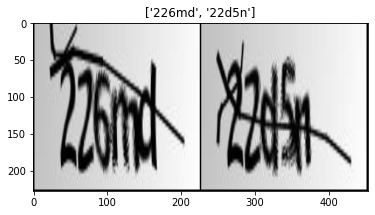

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

# 학습 데이터의 배치를 얻습니다.
# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 64로 했으니 사진 64장이 로드된다.
dataiter = iter(train_dl)
inputs, label_oh, classes = dataiter.next()


# 배치로부터 격자 형태의 이미지를 만듭니다.
# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
# 로드된 데이터 중에서 4개만 추출한다.
out = torchvision.utils.make_grid(inputs[:2])

# 이미지를 출력한다.
imshow(out, title=[x for x in classes[:2]])



In [10]:
print("inputs")
print(inputs[0])
print(inputs.size())

inputs
tensor([[[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]]])
torch.Size([64, 1, 224, 224])


In [11]:
print("label_oh")
print(label_oh[0])
print(label_oh.size())

label_oh
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
torch.Size([64, 180])


In [12]:
print("classes")
print(classes[0])
print(len(classes))

classes
226md
64


### ResNet18 모델기반 신경망 정의하기

이제 신경망을 정의해보겠습니다

Transfer Learning의 핵심! Pretrained model을 가져온다. 본 예제에서는 ResNet18 모델을 이용하였다. model_ft.fc.in_features는 ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다. Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델이 된다. 가장 핵심이지만 가장 심플하다고 할 수 있다.

​

*이 때, Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같아야한다.

본 예제는 캡차에 적용된 영숫자와 인식필요 캡차영숫자의 곱으로 이루어진 ALL_CHAR_SET_LEN*MAX_CAPTCHA이므로, 출력 노드 갯수는 ALL_CHAR_SET_LEN*MAX_CAPTCHA가 된다.

In [13]:
def get_model():
    """
    """
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)
    return model

# 모델 정의 
model = get_model().to(device)


### 손실함수정의

In [14]:
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

### 모델 학습하기


In [15]:
since = time.time()
num_epochs = 50
for epoch in range(num_epochs):
    print(' ' * 50)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = Variable(img).to(device)
        label_oh = Variable(label_oh.float()).to(device)
        pred = model(img)
        loss = loss_func(pred, label_oh)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('step:', step+1, 'loss:', loss.item())

time_elapsed = time.time() - since
print('=' * 50)
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


                                                  
Epoch 1/50
----------
step: 1 loss: 0.7164050340652466
step: 2 loss: 0.5159693956375122
step: 3 loss: 0.3474055528640747
step: 4 loss: 0.24043798446655273
step: 5 loss: 0.17724251747131348
step: 6 loss: 0.1475776731967926
step: 7 loss: 0.13831952214241028
step: 8 loss: 0.12912264466285706
step: 9 loss: 0.12651458382606506
step: 10 loss: 0.12847411632537842
step: 11 loss: 0.13063088059425354
step: 12 loss: 0.13156355917453766
step: 13 loss: 0.1387942135334015
step: 14 loss: 0.13315021991729736
step: 15 loss: 0.13045620918273926
step: 16 loss: 0.12672822177410126
                                                  
Epoch 2/50
----------
step: 1 loss: 0.12361475825309753
step: 2 loss: 0.12217305600643158
step: 3 loss: 0.12038978934288025
step: 4 loss: 0.11498373746871948
step: 5 loss: 0.11393453925848007
step: 6 loss: 0.11146018654108047
step: 7 loss: 0.11025591194629669
step: 8 loss: 0.10916104912757874
step: 9 loss: 0.11175067722797394
st

step: 2 loss: 0.062265463173389435
step: 3 loss: 0.06210683658719063
step: 4 loss: 0.062048472464084625
step: 5 loss: 0.06425067782402039
step: 6 loss: 0.06194246560335159
step: 7 loss: 0.06277036666870117
step: 8 loss: 0.05746300518512726
step: 9 loss: 0.05641665682196617
step: 10 loss: 0.0591476634144783
step: 11 loss: 0.059081729501485825
step: 12 loss: 0.06875840574502945
step: 13 loss: 0.05952213704586029
step: 14 loss: 0.05349428206682205
step: 15 loss: 0.06125130504369736
step: 16 loss: 0.05553857609629631
                                                  
Epoch 15/50
----------
step: 1 loss: 0.05911991745233536
step: 2 loss: 0.05619601905345917
step: 3 loss: 0.0571896955370903
step: 4 loss: 0.05585307255387306
step: 5 loss: 0.058041997253894806
step: 6 loss: 0.05667613819241524
step: 7 loss: 0.056193187832832336
step: 8 loss: 0.052253685891628265
step: 9 loss: 0.04945143312215805
step: 10 loss: 0.05316765978932381
step: 11 loss: 0.05473729968070984
step: 12 loss: 0.063114143908

step: 2 loss: 0.015178626403212547
step: 3 loss: 0.016345398500561714
step: 4 loss: 0.015359438955783844
step: 5 loss: 0.013545947149395943
step: 6 loss: 0.019600598141551018
step: 7 loss: 0.017390176653862
step: 8 loss: 0.013976411893963814
step: 9 loss: 0.01240435242652893
step: 10 loss: 0.011592064052820206
step: 11 loss: 0.016663571819663048
step: 12 loss: 0.022921916097402573
step: 13 loss: 0.02059324085712433
step: 14 loss: 0.010618142783641815
step: 15 loss: 0.011279472149908543
step: 16 loss: 0.0193921085447073
                                                  
Epoch 28/50
----------
step: 1 loss: 0.017399707809090614
step: 2 loss: 0.015002218075096607
step: 3 loss: 0.01183395553380251
step: 4 loss: 0.013078320771455765
step: 5 loss: 0.011665640398859978
step: 6 loss: 0.018378376960754395
step: 7 loss: 0.013648537918925285
step: 8 loss: 0.009757498279213905
step: 9 loss: 0.01184867788106203
step: 10 loss: 0.012273124419152737
step: 11 loss: 0.015037145465612411
step: 12 loss: 0

step: 1 loss: 0.004956607706844807
step: 2 loss: 0.0052039441652596
step: 3 loss: 0.004124896600842476
step: 4 loss: 0.00369785213842988
step: 5 loss: 0.0033214048016816378
step: 6 loss: 0.0046656145714223385
step: 7 loss: 0.00428837351500988
step: 8 loss: 0.00324660399928689
step: 9 loss: 0.003241622354835272
step: 10 loss: 0.003105259034782648
step: 11 loss: 0.004021365195512772
step: 12 loss: 0.006065574940294027
step: 13 loss: 0.005985473282635212
step: 14 loss: 0.002716214396059513
step: 15 loss: 0.0029575470834970474
step: 16 loss: 0.0049173468723893166
                                                  
Epoch 41/50
----------
step: 1 loss: 0.0036043536383658648
step: 2 loss: 0.003264422994107008
step: 3 loss: 0.0036571472883224487
step: 4 loss: 0.003138774773105979
step: 5 loss: 0.003120213281363249
step: 6 loss: 0.004755817353725433
step: 7 loss: 0.003750004805624485
step: 8 loss: 0.002735065296292305
step: 9 loss: 0.002544560469686985
step: 10 loss: 0.0023538311943411827
step: 

### 모델 예측값 시각화하기
일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    test_correct = 0
    test_total = len(test_dl.dataset)

    with torch.no_grad():
        for i, (inputs, label_oh, label) in enumerate(test_dl):
            
            view_image = torchvision.utils.make_grid(inputs)
            inputs = Variable(inputs).to(device)
#             labels = labels.to(device)

            outputs = model(inputs)
    
            c0 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
            c1 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
            c2 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
            c3 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
            c4 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
            preds_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

            correct = ""
            if label[0] == preds_label:
                test_correct += 1
                correct = "True"
            else:
                correct = "False"
                
            
            print("Lable : {} Prediction Lable : {} 맟춤여부 : {}".format(label[0], preds_label, correct))

            # 맞추지 못한 이미지를 출력한다.
            if (correct == "False") and (num_images > i):
                imshow(view_image, title='{} predicted: {}  {}'.format(i+1, preds_label, correct))

        model.train(mode=was_training)
        
    print(f'Test Accuracy: {(test_correct/test_total):.5f} ' +  f'({test_correct}/{test_total})')


### 모델 학습결과 테스트 데이터로 테스트

In [17]:
visualize_model(model)

Lable : 226md Prediction Lable : 226md 맟춤여부 : True
Lable : 22d5n Prediction Lable : 22d5n 맟춤여부 : True
Lable : 2356g Prediction Lable : 2356g 맟춤여부 : True
Lable : 23mdg Prediction Lable : 23mdg 맟춤여부 : True
Lable : 23n88 Prediction Lable : 23n88 맟춤여부 : True
Lable : 243mm Prediction Lable : 243mm 맟춤여부 : True
Lable : 244e2 Prediction Lable : 244e2 맟춤여부 : True
Lable : 245y5 Prediction Lable : 245y5 맟춤여부 : True
Lable : 24f6w Prediction Lable : 24f6w 맟춤여부 : True
Lable : 24pew Prediction Lable : 24pew 맟춤여부 : True
Lable : 25257 Prediction Lable : 25257 맟춤여부 : True
Lable : 253dc Prediction Lable : 253dc 맟춤여부 : True
Lable : 25egp Prediction Lable : 25egp 맟춤여부 : True
Lable : 25m6p Prediction Lable : 25m6p 맟춤여부 : True
Lable : 25p2m Prediction Lable : 25p2m 맟춤여부 : True
Lable : 25w53 Prediction Lable : 25w53 맟춤여부 : True
Lable : 264m5 Prediction Lable : 264m5 맟춤여부 : True
Lable : 268g2 Prediction Lable : 268g2 맟춤여부 : True
Lable : 28348 Prediction Lable : 28348 맟춤여부 : True
Lable : 28x47 Prediction Lable 

Lable : 5n245 Prediction Lable : 5n245 맟춤여부 : True
Lable : 5n3w4 Prediction Lable : 5n3w4 맟춤여부 : True
Lable : 5n728 Prediction Lable : 5n728 맟춤여부 : True
Lable : 5n732 Prediction Lable : 5n732 맟춤여부 : True
Lable : 5ng6e Prediction Lable : 5ng6e 맟춤여부 : True
Lable : 5nggg Prediction Lable : 5nggg 맟춤여부 : True
Lable : 5nm6d Prediction Lable : 5nm6d 맟춤여부 : True
Lable : 5nnff Prediction Lable : 5nnff 맟춤여부 : True
Lable : 5np4m Prediction Lable : 5np4m 맟춤여부 : True
Lable : 5npdn Prediction Lable : 5npdn 맟춤여부 : True
Lable : 5nxnn Prediction Lable : 5nxnn 맟춤여부 : True
Lable : 5p3mm Prediction Lable : 5p3mm 맟춤여부 : True
Lable : 5p8fm Prediction Lable : 5p8fm 맟춤여부 : True
Lable : 5pm6b Prediction Lable : 5pm6b 맟춤여부 : True
Lable : 5wddw Prediction Lable : 5wddw 맟춤여부 : True
Lable : 5x5nx Prediction Lable : 5x5nx 맟춤여부 : True
Lable : 5x7x5 Prediction Lable : 5x7x5 맟춤여부 : True
Lable : 5xd2e Prediction Lable : 5xd2e 맟춤여부 : True
Lable : 5xwcg Prediction Lable : 5xwcg 맟춤여부 : True
Lable : 5ywwf Prediction Lable 

Lable : 8nbew Prediction Lable : 8nbew 맟춤여부 : True
Lable : 8ne4g Prediction Lable : 8ne4g 맟춤여부 : True
Lable : 8nn73 Prediction Lable : 8nn73 맟춤여부 : True
Lable : 8np22 Prediction Lable : 8np22 맟춤여부 : True
Lable : 8npd5 Prediction Lable : 8npd5 맟춤여부 : True
Lable : 8npe3 Prediction Lable : 8npe3 맟춤여부 : True
Lable : 8pfxx Prediction Lable : 8pfxx 맟춤여부 : True
Lable : 8w754 Prediction Lable : 8w754 맟춤여부 : True
Lable : 8w875 Prediction Lable : 8w875 맟춤여부 : True
Lable : 8wy7d Prediction Lable : 8wy7d 맟춤여부 : True
Lable : 8xef7 Prediction Lable : 8xef7 맟춤여부 : True
Lable : 8y63f Prediction Lable : 8y63f 맟춤여부 : True
Lable : 8y6b3 Prediction Lable : 8y6b3 맟춤여부 : True
Lable : 8ypdn Prediction Lable : 8ypdn 맟춤여부 : True
Lable : b26nd Prediction Lable : b26nd 맟춤여부 : True
Lable : b28g8 Prediction Lable : b28g8 맟춤여부 : True
Lable : b2g8e Prediction Lable : b2g8e 맟춤여부 : True
Lable : b2nen Prediction Lable : b2nen 맟춤여부 : True
Lable : b35f6 Prediction Lable : b35f6 맟춤여부 : True
Lable : b3xpn Prediction Lable 

Lable : e3ndn Prediction Lable : e3ndn 맟춤여부 : True
Lable : e43ym Prediction Lable : e43ym 맟춤여부 : True
Lable : e46pd Prediction Lable : e46pd 맟춤여부 : True
Lable : e46yw Prediction Lable : e46yw 맟춤여부 : True
Lable : e4gd7 Prediction Lable : e4gd7 맟춤여부 : True
Lable : e5n66 Prediction Lable : e5n66 맟춤여부 : True
Lable : e667x Prediction Lable : e667x 맟춤여부 : True
Lable : e6b7y Prediction Lable : e6b7y 맟춤여부 : True
Lable : e6m6p Prediction Lable : e6m6p 맟춤여부 : True
Lable : e72cd Prediction Lable : e72cd 맟춤여부 : True
Lable : e76n4 Prediction Lable : e76n4 맟춤여부 : True
Lable : e7nx4 Prediction Lable : e7nx4 맟춤여부 : True
Lable : e7x45 Prediction Lable : e7x45 맟춤여부 : True
Lable : e84n2 Prediction Lable : e84n2 맟춤여부 : True
Lable : e8dxn Prediction Lable : e8dxn 맟춤여부 : True
Lable : e8e5e Prediction Lable : e8e5e 맟춤여부 : True
Lable : ebcbx Prediction Lable : ebcbx 맟춤여부 : True
Lable : ec6pm Prediction Lable : ec6pm 맟춤여부 : True
Lable : ecd4w Prediction Lable : ecd4w 맟춤여부 : True
Lable : edg3p Prediction Lable 

Lable : mfc35 Prediction Lable : mfc35 맟춤여부 : True
Lable : mg5nn Prediction Lable : mg5nn 맟춤여부 : True
Lable : mgdwb Prediction Lable : mgdwb 맟춤여부 : True
Lable : mggce Prediction Lable : mggce 맟춤여부 : True
Lable : mgw3n Prediction Lable : mgw3n 맟춤여부 : True
Lable : mm3nn Prediction Lable : mm3nn 맟춤여부 : True
Lable : mmc5n Prediction Lable : mmc5n 맟춤여부 : True
Lable : mmfm6 Prediction Lable : mmfm6 맟춤여부 : True
Lable : mmg2m Prediction Lable : mmg2m 맟춤여부 : True
Lable : mmg38 Prediction Lable : mmg38 맟춤여부 : True
Lable : mmy5n Prediction Lable : mmy5n 맟춤여부 : True
Lable : mn5c4 Prediction Lable : mn5c4 맟춤여부 : True
Lable : mnef5 Prediction Lable : mnef5 맟춤여부 : True
Lable : mp7wp Prediction Lable : mp7wp 맟춤여부 : True
Lable : mpmy5 Prediction Lable : mpmy5 맟춤여부 : True
Lable : mpxfb Prediction Lable : mpxfb 맟춤여부 : True
Lable : mw5p2 Prediction Lable : mw5p2 맟춤여부 : True
Lable : mwdf6 Prediction Lable : mwdf6 맟춤여부 : True
Lable : mwxwp Prediction Lable : mwxwp 맟춤여부 : True
Lable : mx8bb Prediction Lable 

Lable : pp546 Prediction Lable : pp546 맟춤여부 : True
Lable : pp87n Prediction Lable : pp87n 맟춤여부 : True
Lable : ppwyd Prediction Lable : ppwyd 맟춤여부 : True
Lable : ppx77 Prediction Lable : ppx77 맟춤여부 : True
Lable : pw5nc Prediction Lable : pw5nc 맟춤여부 : True
Lable : pwebm Prediction Lable : pwebm 맟춤여부 : True
Lable : pwmbn Prediction Lable : pwmbn 맟춤여부 : True
Lable : pwn5e Prediction Lable : pwn5e 맟춤여부 : True
Lable : px2xp Prediction Lable : px2xp 맟춤여부 : True
Lable : px8n8 Prediction Lable : px8n8 맟춤여부 : True
Lable : pxdwp Prediction Lable : pxdwp 맟춤여부 : True
Lable : pxne8 Prediction Lable : pxne8 맟춤여부 : True
Lable : pybee Prediction Lable : pybee 맟춤여부 : True
Lable : pyefb Prediction Lable : pyefb 맟춤여부 : True
Lable : pyf65 Prediction Lable : pyf65 맟춤여부 : True
Lable : pym7p Prediction Lable : pym7p 맟춤여부 : True
Lable : w2e87 Prediction Lable : w2e87 맟춤여부 : True
Lable : w2n7e Prediction Lable : w2n7e 맟춤여부 : True
Lable : w2yp7 Prediction Lable : w2yp7 맟춤여부 : True
Lable : w46ep Prediction Lable 

<Figure size 432x288 with 0 Axes>

### 학습한 모델 저장
지금까지 인공신경망을 구현하고 학습시켜 보았습니다. 이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [18]:
torch.save(model.state_dict(), 'model/CaptchaBreaking_Model.pt')
print("save last model")


save last model


save() 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 CaptchaBreaking_Model.pt 라는 파일이 생성됩니다.

아래 코드처럼 CaptchaBreaking_Model.pt를 다시 load하는 것도 가능합니다.

In [19]:
new_model = get_model().to(device)
new_model = new_model.eval()
new_model.load_state_dict(torch.load('model/CaptchaBreaking_Model.pt'))
print("load saved_model.")


load saved_model.


업로드한 모델로 다시한번 테스트

In [20]:
visualize_model(new_model)

Lable : 226md Prediction Lable : 226md 맟춤여부 : True
Lable : 22d5n Prediction Lable : 22d5n 맟춤여부 : True
Lable : 2356g Prediction Lable : 2356g 맟춤여부 : True
Lable : 23mdg Prediction Lable : 23mdg 맟춤여부 : True
Lable : 23n88 Prediction Lable : 23n88 맟춤여부 : True
Lable : 243mm Prediction Lable : 243mm 맟춤여부 : True
Lable : 244e2 Prediction Lable : 244e2 맟춤여부 : True
Lable : 245y5 Prediction Lable : 245y5 맟춤여부 : True
Lable : 24f6w Prediction Lable : 24f6w 맟춤여부 : True
Lable : 24pew Prediction Lable : 24pew 맟춤여부 : True
Lable : 25257 Prediction Lable : 25257 맟춤여부 : True
Lable : 253dc Prediction Lable : 253dc 맟춤여부 : True
Lable : 25egp Prediction Lable : 25egp 맟춤여부 : True
Lable : 25m6p Prediction Lable : 25m6p 맟춤여부 : True
Lable : 25p2m Prediction Lable : 25p2m 맟춤여부 : True
Lable : 25w53 Prediction Lable : 25w53 맟춤여부 : True
Lable : 264m5 Prediction Lable : 264m5 맟춤여부 : True
Lable : 268g2 Prediction Lable : 268g2 맟춤여부 : True
Lable : 28348 Prediction Lable : 28348 맟춤여부 : True
Lable : 28x47 Prediction Lable 

Lable : 5f3gf Prediction Lable : 5f3gf 맟춤여부 : True
Lable : 5fyem Prediction Lable : 5fyem 맟춤여부 : True
Lable : 5g5e5 Prediction Lable : 5g5e5 맟춤여부 : True
Lable : 5gcd3 Prediction Lable : 5gcd3 맟춤여부 : True
Lable : 5mcy7 Prediction Lable : 5mcy7 맟춤여부 : True
Lable : 5mf7c Prediction Lable : 5mf7c 맟춤여부 : True
Lable : 5mfff Prediction Lable : 5mfff 맟춤여부 : True
Lable : 5mgn4 Prediction Lable : 5mgn4 맟춤여부 : True
Lable : 5mnpd Prediction Lable : 5mnpd 맟춤여부 : True
Lable : 5n245 Prediction Lable : 5n245 맟춤여부 : True
Lable : 5n3w4 Prediction Lable : 5n3w4 맟춤여부 : True
Lable : 5n728 Prediction Lable : 5n728 맟춤여부 : True
Lable : 5n732 Prediction Lable : 5n732 맟춤여부 : True
Lable : 5ng6e Prediction Lable : 5ng6e 맟춤여부 : True
Lable : 5nggg Prediction Lable : 5nggg 맟춤여부 : True
Lable : 5nm6d Prediction Lable : 5nm6d 맟춤여부 : True
Lable : 5nnff Prediction Lable : 5nnff 맟춤여부 : True
Lable : 5np4m Prediction Lable : 5np4m 맟춤여부 : True
Lable : 5npdn Prediction Lable : 5npdn 맟춤여부 : True
Lable : 5nxnn Prediction Lable 

Lable : 8n5p3 Prediction Lable : 8n5p3 맟춤여부 : True
Lable : 8n5pn Prediction Lable : 8n5pn 맟춤여부 : True
Lable : 8n62n Prediction Lable : 8n62n 맟춤여부 : True
Lable : 8n65n Prediction Lable : 8n65n 맟춤여부 : True
Lable : 8nbew Prediction Lable : 8nbew 맟춤여부 : True
Lable : 8ne4g Prediction Lable : 8ne4g 맟춤여부 : True
Lable : 8nn73 Prediction Lable : 8nn73 맟춤여부 : True
Lable : 8np22 Prediction Lable : 8np22 맟춤여부 : True
Lable : 8npd5 Prediction Lable : 8npd5 맟춤여부 : True
Lable : 8npe3 Prediction Lable : 8npe3 맟춤여부 : True
Lable : 8pfxx Prediction Lable : 8pfxx 맟춤여부 : True
Lable : 8w754 Prediction Lable : 8w754 맟춤여부 : True
Lable : 8w875 Prediction Lable : 8w875 맟춤여부 : True
Lable : 8wy7d Prediction Lable : 8wy7d 맟춤여부 : True
Lable : 8xef7 Prediction Lable : 8xef7 맟춤여부 : True
Lable : 8y63f Prediction Lable : 8y63f 맟춤여부 : True
Lable : 8y6b3 Prediction Lable : 8y6b3 맟춤여부 : True
Lable : 8ypdn Prediction Lable : 8ypdn 맟춤여부 : True
Lable : b26nd Prediction Lable : b26nd 맟춤여부 : True
Lable : b28g8 Prediction Lable 

Lable : dfnx4 Prediction Lable : dfnx4 맟춤여부 : True
Lable : dgcm4 Prediction Lable : dgcm4 맟춤여부 : True
Lable : dmw8n Prediction Lable : dmw8n 맟춤여부 : True
Lable : dmx8p Prediction Lable : dmx8p 맟춤여부 : True
Lable : dmxp8 Prediction Lable : dmxp8 맟춤여부 : True
Lable : dn26n Prediction Lable : dn26n 맟춤여부 : True
Lable : dn2ym Prediction Lable : dn2ym 맟춤여부 : True
Lable : dn5df Prediction Lable : dn5df 맟춤여부 : True
Lable : dnmd8 Prediction Lable : dnmd8 맟춤여부 : True
Lable : dnne7 Prediction Lable : dnne7 맟춤여부 : True
Lable : dnxdp Prediction Lable : dnxdp 맟춤여부 : True
Lable : dpbyd Prediction Lable : dpbyd 맟춤여부 : True
Lable : dw3nn Prediction Lable : dw3nn 맟춤여부 : True
Lable : dw6mn Prediction Lable : dw6mn 맟춤여부 : True
Lable : dw8d3 Prediction Lable : dw8d3 맟춤여부 : True
Lable : dxwcw Prediction Lable : dxwcw 맟춤여부 : True
Lable : dy3cx Prediction Lable : dy3cx 맟춤여부 : True
Lable : dyp7n Prediction Lable : dyp7n 맟춤여부 : True
Lable : dyxnc Prediction Lable : dyxnc 맟춤여부 : True
Lable : e25xg Prediction Lable 

Lable : gny6b Prediction Lable : gny6b 맟춤여부 : True
Lable : gp22x Prediction Lable : gp22x 맟춤여부 : True
Lable : gp7c5 Prediction Lable : gp7c5 맟춤여부 : True
Lable : gpnxn Prediction Lable : gpnxn 맟춤여부 : True
Lable : gpxng Prediction Lable : gpxng 맟춤여부 : True
Lable : gw468 Prediction Lable : gw468 맟춤여부 : True
Lable : gw53m Prediction Lable : gw53m 맟춤여부 : True
Lable : gwn53 Prediction Lable : gwn53 맟춤여부 : True
Lable : gwnm6 Prediction Lable : gwnm6 맟춤여부 : True
Lable : gxx2p Prediction Lable : gxx2p 맟춤여부 : True
Lable : gxxpf Prediction Lable : gxxpf 맟춤여부 : True
Lable : gy433 Prediction Lable : gy433 맟춤여부 : True
Lable : gy5bf Prediction Lable : gy5bf 맟춤여부 : True
Lable : gy8xb Prediction Lable : gy8xb 맟춤여부 : True
Lable : gymmn Prediction Lable : gymmn 맟춤여부 : True
Lable : m22e3 Prediction Lable : m22e3 맟춤여부 : True
Lable : m23bp Prediction Lable : m23bp 맟춤여부 : True
Lable : m2576 Prediction Lable : m2576 맟춤여부 : True
Lable : m2nf4 Prediction Lable : m2nf4 맟춤여부 : True
Lable : m3588 Prediction Lable 

Lable : ny8np Prediction Lable : ny8np 맟춤여부 : True
Lable : nybcx Prediction Lable : nybcx 맟춤여부 : True
Lable : p24gn Prediction Lable : p24gn 맟춤여부 : True
Lable : p2dw7 Prediction Lable : p2dw7 맟춤여부 : True
Lable : p2m6n Prediction Lable : p2m6n 맟춤여부 : True
Lable : p2x7x Prediction Lable : p2x7x 맟춤여부 : True
Lable : p2ym2 Prediction Lable : p2ym2 맟춤여부 : True
Lable : p4nm4 Prediction Lable : p4nm4 맟춤여부 : True
Lable : p4pde Prediction Lable : p4pde 맟춤여부 : True
Lable : p57fn Prediction Lable : p57fn 맟춤여부 : True
Lable : p5g5m Prediction Lable : p5g5m 맟춤여부 : True
Lable : p5nce Prediction Lable : p5nce 맟춤여부 : True
Lable : p6mn8 Prediction Lable : p6mn8 맟춤여부 : True
Lable : p7fyp Prediction Lable : p7fyp 맟춤여부 : True
Lable : p8c24 Prediction Lable : p8c24 맟춤여부 : True
Lable : p8ngx Prediction Lable : p8ngx 맟춤여부 : True
Lable : p8wwf Prediction Lable : p8wwf 맟춤여부 : True
Lable : pbpgc Prediction Lable : pbpgc 맟춤여부 : True
Lable : pcede Prediction Lable : pcede 맟춤여부 : True
Lable : pcm7f Prediction Lable 

<Figure size 432x288 with 0 Axes>

### 학습모델이용 이미지 숫자인식
이미지 파일을 주고 이미지 파일 내에 있는 글자를 출력한다

type: <class 'PIL.PngImagePlugin.PngImageFile'>
size of image: (200, 50)


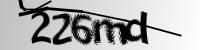

In [21]:
# 코드 3-1

import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('captcha-version-2-images/samples/samples/226md.png')
# PIL 객체 확인
print("type: {}".format(type(img)))
# 이미지 흑백으로 변경, 크기변화: 150x150x3 > 150x150x1
img = img.convert("L") 
# 이미지 크기 조회
print("size of image: {}".format(img.size))
img

In [22]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    # Load Image
    img = img.convert('L')
    # Resize Image [1, 224, 224]
    img = transform(img)
    
    # Turn image into numpy array
    img = np.array(img)
    
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
#     # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

torch.Size([1, 1, 224, 224])


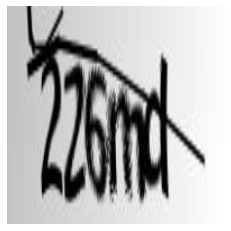

In [23]:
input = process_image('captcha-version-2-images/samples/samples/226md.png')
print(input.size())
plt.imshow(input.squeeze().detach().numpy(), cmap="gray")
plt.axis("off")
plt.show()
# image = input[:,0][:,None].type(torch.FloatTensor).to(device) # select only 1 channel (all channel equal)
# print(image.size())


In [24]:
def get_predict(model, path):

    model.eval()
    predict_label = ""
    input = process_image(path)
    print(input.size())
    
    img = Variable(input).to(device)

    output = model(img)

    c0 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    predict_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

   
    return predict_label
    


In [25]:
get_predict(new_model, 'captcha-version-2-images/samples/samples/226md.png')

torch.Size([1, 1, 224, 224])


'226md'